# Experiment Runner

### Consumes transcoder stream according to the traffic trace and records QoS metrics

In [185]:
import vlc
import os
import time
import pandas as pd
import numpy as np
import requests
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

In [186]:
STREAM_URL = 'http://131.234.250.116:9000/data/stream_1.m3u8'

class ExperimentClient():
    def __init__(self, url=STREAM_URL):
        stream_url = url
        instance = vlc.Instance("--vout=dummy --aout=dummy".split())
        
        self.media = instance.media_new(stream_url)
        self.player = instance.media_player_new()

        self.player.set_media(self.media)

        self.bitrates = []
        self.playing_time = 0

    def restart_player(self):
        self.player.stop()
        self.player.play()

    def start_player(self):
        self.player.play()

    def stop_player(self):
        self.player.stop()

    def consume_stream_proc(self, timeblock, return_dict):
        _counter = 0
        _just_starting = True
        self.start_player()
        # init_time = time.time()
        previous_bitrate = 0.0
        _same_bitrate_count = 0
        SAME_BITRATE_THRESHOLD = 2
        time.sleep(1)
        while(_counter < timeblock+1):
            try:
                stats = vlc.MediaStats() 
                state = str(self.media.get_state())
                _bitrate = 0.0
                if state in ["State.Opening", "State.Buffering", "State.Playing"]:
                    self.media.get_stats(stats)
                    _bitrate = stats.demux_bitrate*8000.0
                    # print("Bitrate")
                    # print(_bitrate)
                    # print(state)
                    if _bitrate == 0.0:
                        if _just_starting:
                            print("Streaming just started...")
                            _just_starting = False
                        else:
                            print("No data yet...")
                            return_dict['down_time'] += 1
                    else:
                        if _bitrate == previous_bitrate:
                            if _same_bitrate_count >= SAME_BITRATE_THRESHOLD:
                                _same_bitrate_count = 0
                                print("Bitrate seems to be same, stream stuck? - Retrying...")
                                return_dict['down_time'] += SAME_BITRATE_THRESHOLD + 1
                                return_dict['playing_time'] -= SAME_BITRATE_THRESHOLD
                                self.restart_player()
                            else:
                                print("Same bitrate!")
                                _same_bitrate_count += 1
                                return_dict['bitrates'].append(_bitrate)
                                return_dict['playing_time'] += 1
                        else:
                            _same_bitrate_count = 0
                            return_dict['bitrates'].append(_bitrate)
                            return_dict['playing_time'] += 1

                else:
                    if _just_starting:
                        print("Streaming just started...")
                        _just_starting = False                    
                    else:
                        print("Streaming not 'Playing' - Retrying...")
                        return_dict['down_time'] += 1                    
                        self.restart_player()

            except Exception as e:
                print(e)

            print(state, return_dict["bitrates"][-3:], "P:", return_dict["playing_time"], "D:", return_dict["down_time"])
            previous_bitrate = _bitrate
            time.sleep(1)
            _counter += 1

        self.stop_player()        
        return return_dict


In [187]:
MANO_URL = "thesismano1.cs.upb.de"

def set_remote_version(version, host=MANO_URL, port=8898) :
    if "virtual_deployment_units_vm" in version:
        switch_type="VM"
    if "virtual_deployment_units_gpu" in version:
        switch_type="GPU"
    if "virtual_deployment_units_con" in version:
        switch_type="CON"

    _base_path = 'http://{0}:{1}/switch_version?version={2}'.format(host, port, switch_type)

    try:
        r = requests.get(_base_path, verify=False)
        # print("Switch Version")
        print("Switch Version: ", r.text)
    except Exception as e:
        print(e)
        print("Switch version could'nt be set")


## Read Policy Trace

In [188]:
LOOK_AHEAD = 5 # Mins
TIMEBLOCK = LOOK_AHEAD * 60 # Sec
EXPERIMENT_TIME = 720
EXPERIMENT_TIME_START = 3325
EXPERIMENT_TIME_STOP = EXPERIMENT_TIME_START + (EXPERIMENT_TIME/LOOK_AHEAD)
EXPERIMENT_START_TIME = int(time.time())

traffic_trace_complete = pd.read_csv(r'./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD), index_col=0)

policy_trace = traffic_trace_complete[['policy']].iloc[EXPERIMENT_TIME_START:int(EXPERIMENT_TIME_STOP)].reset_index()
history_trace = traffic_trace_complete[['history']].iloc[EXPERIMENT_TIME_START:int(EXPERIMENT_TIME_STOP)].reset_index()

print(policy_trace.shape)

print("\nPolicy")
print(policy_trace['policy'].value_counts())

print("\nHistory")
print(history_trace['history'].value_counts())

# print(policy_trace)

(144, 2)

Policy
virtual_deployment_units_con:transcoder-image-1-con    139
virtual_deployment_units_gpu:transcoder-image-1-gpu      5
Name: policy, dtype: int64

History
virtual_deployment_units_con:transcoder-image-1-con    134
virtual_deployment_units_vm:transcoder-image-1-vm        6
virtual_deployment_units_gpu:transcoder-image-1-gpu      4
Name: history, dtype: int64


# Run Experiments

## 1. Policy Experiment

In [189]:
# TIMEBLOCK = 60

# Setting initial version and waiting
set_remote_version(policy_trace['policy'][0])
time.sleep(30)

for index_label, row_series in policy_trace.iterrows():

    print("Running Experiment at: ", index_label, " For: ", row_series['policy'])

    # Switch version on MANO
    set_remote_version(row_series['policy'])

    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    return_dict["bitrates"] = manager.list()
    return_dict["playing_time"] = 0
    return_dict["down_time"] = 0

    _runner = ExperimentClient()

    p = multiprocessing.Process(target=_runner.consume_stream_proc, args=(TIMEBLOCK, return_dict))
    p.start()

    p.join()

    print("\n####################")
    print(np.mean(return_dict["bitrates"]), return_dict["playing_time"], return_dict["down_time"])
    print("####################\n")

    p.terminate()

    ################
    # Store Results 
    ################
    policy_trace.at[index_label , 'avg_datarate'] = np.mean(return_dict["bitrates"])
    policy_trace.at[index_label , 'playing_time'] = return_dict["playing_time"]
    policy_trace.at[index_label , 'down_time'] = return_dict["down_time"]

    clear_output(wait=True)


Running Experiment at:  143  For:  virtual_deployment_units_con:transcoder-image-1-con
Switch Version:  Done
Streaming just started...
State.Playing [] P: 0 D: 0
State.Playing [919.9492931365967] P: 1 D: 0
State.Playing [919.9492931365967, 233.42013359069824] P: 2 D: 0
Same bitrate!
State.Playing [919.9492931365967, 233.42013359069824, 233.42013359069824] P: 3 D: 0
State.Playing [233.42013359069824, 233.42013359069824, 342.8136706352234] P: 4 D: 0
State.Playing [233.42013359069824, 342.8136706352234, 906.3434600830078] P: 5 D: 0
State.Playing [342.8136706352234, 906.3434600830078, 732.4860692024231] P: 6 D: 0
State.Playing [906.3434600830078, 732.4860692024231, 808.223307132721] P: 7 D: 0
State.Playing [732.4860692024231, 808.223307132721, 683.3372116088867] P: 8 D: 0
State.Playing [808.223307132721, 683.3372116088867, 735.5667948722839] P: 9 D: 0
State.Playing [683.3372116088867, 735.5667948722839, 743.5018420219421] P: 10 D: 0
State.Playing [735.5667948722839, 743.5018420219421, 833.

State.Playing [719.4907069206238, 754.0640234947205, 734.603762626648] P: 98 D: 0
State.Playing [754.0640234947205, 734.603762626648, 818.3750510215759] P: 99 D: 0
State.Playing [734.603762626648, 818.3750510215759, 678.5767078399658] P: 100 D: 0
State.Playing [818.3750510215759, 678.5767078399658, 728.6604642868042] P: 101 D: 0
State.Playing [678.5767078399658, 728.6604642868042, 746.4438080787659] P: 102 D: 0
State.Playing [728.6604642868042, 746.4438080787659, 859.6222996711731] P: 103 D: 0
State.Playing [746.4438080787659, 859.6222996711731, 626.6693472862244] P: 104 D: 0
State.Playing [859.6222996711731, 626.6693472862244, 740.6125664710999] P: 105 D: 0
State.Playing [626.6693472862244, 740.6125664710999, 727.7917861938477] P: 106 D: 0
State.Playing [740.6125664710999, 727.7917861938477, 879.6878457069397] P: 107 D: 0
State.Playing [727.7917861938477, 879.6878457069397, 463.5579288005829] P: 108 D: 0
State.Playing [879.6878457069397, 463.5579288005829, 1005.4229497909546] P: 109 D

State.Playing [729.8362851142883, 751.9155144691467, 734.824001789093] P: 196 D: 0
Same bitrate!
State.Playing [751.9155144691467, 734.824001789093, 734.824001789093] P: 197 D: 0
State.Playing [734.824001789093, 734.824001789093, 1004.7754049301147] P: 198 D: 0
State.Playing [734.824001789093, 1004.7754049301147, 831.8005204200745] P: 199 D: 0
Same bitrate!
State.Playing [1004.7754049301147, 831.8005204200745, 831.8005204200745] P: 200 D: 0
State.Playing [831.8005204200745, 831.8005204200745, 654.7633409500122] P: 201 D: 0
State.Playing [831.8005204200745, 654.7633409500122, 731.3315868377686] P: 202 D: 0
State.Playing [654.7633409500122, 731.3315868377686, 1150.4799127578735] P: 203 D: 0
State.Playing [731.3315868377686, 1150.4799127578735, 690.8883452415466] P: 204 D: 0
Same bitrate!
State.Playing [1150.4799127578735, 690.8883452415466, 690.8883452415466] P: 205 D: 0
State.Playing [690.8883452415466, 690.8883452415466, 701.7325162887573] P: 206 D: 0
State.Playing [690.8883452415466, 

State.Playing [736.3683581352234, 424.39568042755127, 1142.5191164016724] P: 293 D: 0
State.Playing [424.39568042755127, 1142.5191164016724, 669.0952181816101] P: 294 D: 0
State.Playing [1142.5191164016724, 669.0952181816101, 735.1353168487549] P: 295 D: 0
State.Playing [669.0952181816101, 735.1353168487549, 733.6159944534302] P: 296 D: 0
State.Playing [735.1353168487549, 733.6159944534302, 718.1239128112793] P: 297 D: 0
State.Playing [733.6159944534302, 718.1239128112793, 832.4657082557678] P: 298 D: 0
State.Playing [718.1239128112793, 832.4657082557678, 687.1204376220703] P: 299 D: 0
State.Playing [832.4657082557678, 687.1204376220703, 736.1641526222229] P: 300 D: 0

####################
745.4177628954252 300 0
####################



In [215]:
policy_trace = policy_trace.drop('index', axis=1)
policy_trace.to_csv('./data/{}_{}m_policy_qos_results.csv'.format(EXPERIMENT_START_TIME, LOOK_AHEAD))
policy_trace.head()

,policy,avg_datarate,playing_time,down_time
0,virtual_deployment_units_gpu:transcoder-image-...,6588.674266,300.0,0.0
1,virtual_deployment_units_gpu:transcoder-image-...,6046.990230,300.0,0.0
2,virtual_deployment_units_gpu:transcoder-image-...,6052.018270,300.0,0.0
3,virtual_deployment_units_gpu:transcoder-image-...,6750.125998,300.0,0.0
4,virtual_deployment_units_gpu:transcoder-image-...,6688.325912,300.0,0.0


1007.0082560572287
24.0


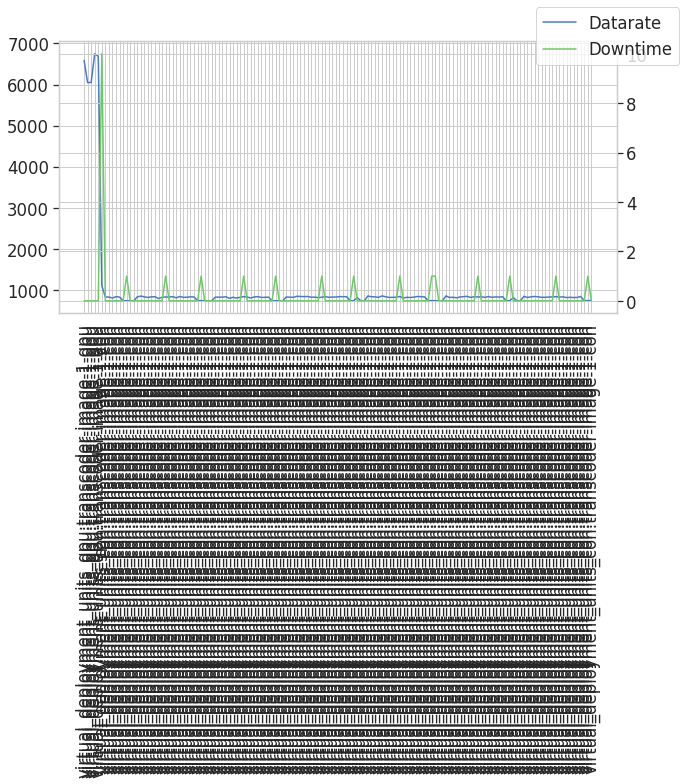

In [191]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xticks(rotation=90)

x = policy_trace.index
y1 = policy_trace['avg_datarate']
y2 = policy_trace['down_time']

ax2 = ax1.twinx()

ind = np.arange(len(x))
width = 0.35
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Bar
# rects1 = ax1.bar(ind - width/2, y1, width, label='Datarate',color = 'b')
# rects2 = ax2.bar(ind + width/2, y2, width, label='Downtime', color = 'g')

# Plot
ax1.plot(x, y1, 'g-', label='Datarate',color = 'b')
ax2.plot(x, y2, 'b-', label='Downtime', color = 'g')

ax1.set_xticks(ind)
ax1.set_xticklabels(policy_trace['policy'])

print(policy_trace['avg_datarate'].mean())
print(policy_trace['down_time'].sum())


fig.legend()
# fig = ax2.get_figure()
plt.show()

## 2. History Experiment

In [192]:
# TIMEBLOCK = 60
# TIMEBLOCK = 60

# Setting initial version and waiting
set_remote_version(history_trace['history'][0])
time.sleep(30)

for index_label, row_series in history_trace.iterrows():

    print("Running Experiment at: ", index_label, " For: ", row_series['history'])

    # Switch version on MANO
    set_remote_version(row_series['history'])

    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    return_dict["bitrates"] = manager.list()
    return_dict["playing_time"] = 0
    return_dict["down_time"] = 0

    _runner = ExperimentClient()

    p = multiprocessing.Process(target=_runner.consume_stream_proc, args=(TIMEBLOCK, return_dict))
    p.start()

    p.join()

    print("\n####################")
    print(np.mean(return_dict["bitrates"]), return_dict["playing_time"], return_dict["down_time"])
    print("####################\n")

    p.terminate()

    ################
    # Store Results 
    ################
    history_trace.at[index_label , 'avg_datarate'] = np.mean(return_dict["bitrates"])
    history_trace.at[index_label , 'playing_time'] = return_dict["playing_time"]
    history_trace.at[index_label , 'down_time'] = return_dict["down_time"]

    clear_output(wait=True)

Running Experiment at:  143  For:  virtual_deployment_units_vm:transcoder-image-1-vm
Switch Version:  Done
Streaming just started...
State.Playing [] P: 0 D: 0
State.Playing [911.9258522987366] P: 1 D: 0
State.Playing [911.9258522987366, 743.4689998626709] P: 2 D: 0
State.Playing [911.9258522987366, 743.4689998626709, 747.8267550468445] P: 3 D: 0
State.Playing [743.4689998626709, 747.8267550468445, 746.5720772743225] P: 4 D: 0
State.Playing [747.8267550468445, 746.5720772743225, 746.4531660079956] P: 5 D: 0
State.Playing [746.5720772743225, 746.4531660079956, 743.7497973442078] P: 6 D: 0
State.Playing [746.4531660079956, 743.7497973442078, 746.1250424385071] P: 7 D: 0
State.Playing [743.7497973442078, 746.1250424385071, 788.2112860679626] P: 8 D: 0
State.Playing [746.1250424385071, 788.2112860679626, 689.7186040878296] P: 9 D: 0
State.Playing [788.2112860679626, 689.7186040878296, 738.9045357704163] P: 10 D: 0
State.Playing [689.7186040878296, 738.9045357704163, 740.8767938613892] P: 1

State.Playing [746.9227910041809, 724.3643999099731, 871.3178634643555] P: 99 D: 0
State.Playing [724.3643999099731, 871.3178634643555, 607.5640320777893] P: 100 D: 0
State.Playing [871.3178634643555, 607.5640320777893, 743.0419921875] P: 101 D: 0
State.Playing [607.5640320777893, 743.0419921875, 746.3065385818481] P: 102 D: 0
State.Playing [743.0419921875, 746.3065385818481, 744.6872591972351] P: 103 D: 0
State.Playing [746.3065385818481, 744.6872591972351, 721.2216854095459] P: 104 D: 0
State.Playing [744.6872591972351, 721.2216854095459, 744.7888255119324] P: 105 D: 0
State.Playing [721.2216854095459, 744.7888255119324, 745.9825277328491] P: 106 D: 0
State.Playing [744.7888255119324, 745.9825277328491, 746.5865612030029] P: 107 D: 0
State.Playing [745.9825277328491, 746.5865612030029, 743.2703971862793] P: 108 D: 0
State.Playing [746.5865612030029, 743.2703971862793, 742.2583103179932] P: 109 D: 0
State.Playing [743.2703971862793, 742.2583103179932, 746.3825941085815] P: 110 D: 0
St

State.Playing [746.1597919464111, 724.2950797080994, 746.7548847198486] P: 197 D: 0
State.Playing [724.2950797080994, 746.7548847198486, 889.3821835517883] P: 198 D: 0
State.Playing [746.7548847198486, 889.3821835517883, 594.5072174072266] P: 199 D: 0
State.Playing [889.3821835517883, 594.5072174072266, 744.1602945327759] P: 200 D: 0
State.Playing [594.5072174072266, 744.1602945327759, 723.9142060279846] P: 201 D: 0
State.Playing [744.1602945327759, 723.9142060279846, 746.6959953308105] P: 202 D: 0
State.Playing [723.9142060279846, 746.6959953308105, 746.6843724250793] P: 203 D: 0
State.Playing [746.6959953308105, 746.6843724250793, 745.8014488220215] P: 204 D: 0
State.Playing [746.6843724250793, 745.8014488220215, 747.7920055389404] P: 205 D: 0
State.Playing [745.8014488220215, 747.7920055389404, 720.8400368690491] P: 206 D: 0
State.Playing [747.7920055389404, 720.8400368690491, 745.5704212188721] P: 207 D: 0
State.Playing [720.8400368690491, 745.5704212188721, 744.3927526473999] P: 2

State.Playing [745.1524138450623, 724.6350049972534, 745.193362236023] P: 295 D: 0
State.Playing [724.6350049972534, 745.193362236023, 741.4299845695496] P: 296 D: 0
State.Playing [745.193362236023, 741.4299845695496, 739.5983934402466] P: 297 D: 0
State.Playing [741.4299845695496, 739.5983934402466, 747.6165294647217] P: 298 D: 0
State.Playing [739.5983934402466, 747.6165294647217, 741.8712973594666] P: 299 D: 0
State.Playing [747.6165294647217, 741.8712973594666, 747.2489476203918] P: 300 D: 0

####################
743.0751232306162 300 0
####################



In [216]:
history_trace = history_trace.drop('index', axis=1)
history_trace.to_csv('./data/{}_{}m_history_qos_results.csv'.format(EXPERIMENT_START_TIME, LOOK_AHEAD))
history_trace.head()

,history,avg_datarate,playing_time,down_time
0,virtual_deployment_units_con:transcoder-image-...,829.886071,300.0,0.0
1,virtual_deployment_units_gpu:transcoder-image-...,6548.036024,290.0,10.0
2,virtual_deployment_units_gpu:transcoder-image-...,6369.936994,300.0,0.0
3,virtual_deployment_units_gpu:transcoder-image-...,6651.827397,300.0,0.0
4,virtual_deployment_units_con:transcoder-image-...,1019.851535,290.0,10.0


992.0475503244727
84.0


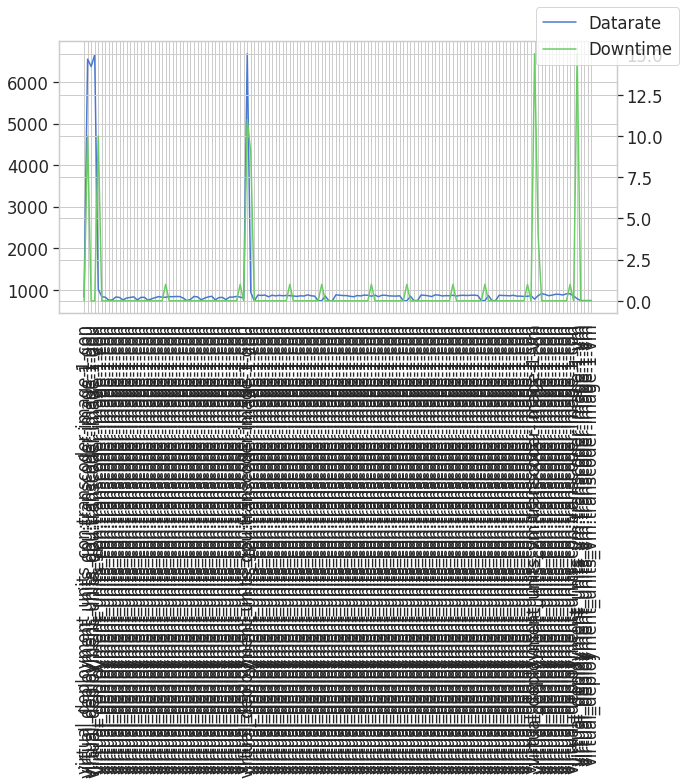

In [211]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xticks(rotation=90)

x = history_trace.index
y1 = history_trace['avg_datarate']
y2 = history_trace['down_time']

ax2 = ax1.twinx()

ind = np.arange(len(x))
width = 0.35
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Bar
# rects1 = ax1.bar(ind - width/2, y1, width, label='Datarate',color = 'b')
# rects2 = ax2.bar(ind + width/2, y2, width, label='Downtime', color = 'g')

# Plot
ax1.plot(x, y1, 'g-', label='Datarate',color = 'b')
ax2.plot(x, y2, 'b-', label='Downtime', color = 'g')

ax1.set_xticks(ind)
ax1.set_xticklabels(history_trace['history'])

print(history_trace['avg_datarate'].mean())
print(history_trace['down_time'].sum())

fig.legend()
# fig = ax2.get_figure()
plt.show()

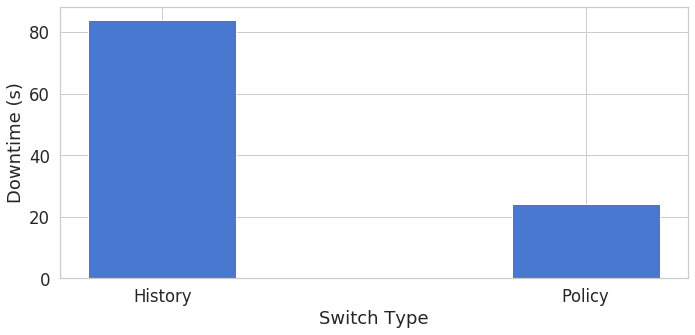

In [212]:
X_LABEL = 'Switch Type'
Y_LABEL = 'Downtime (s)'

down_time = [history_trace['down_time'].sum(), policy_trace['down_time'].sum()]

switch_type = ["History", "Policy"]

ind = np.arange(len(switch_type))
width = 0.35
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(ind, down_time, width, color = 'b')

# Labels, title and custom x-axis tick labels, etc.
ax.set_title('')

ax.set_xlabel(X_LABEL)
ax.set_ylabel(Y_LABEL)
ax.set_xticks(ind)
ax.set_xticklabels(switch_type)

# ax.legend()
fig.tight_layout()

# plt.show()